In [1]:
#this part is not important, only a simple example of scanpy processing to get a list of genes
import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib.pyplot import rc_context

my_data_path = 'path/to/data/outs/filtered_feature_bc_matrix'

def pp(path):
    adata = sc.read_10x_mtx(path)
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
    sc.pp.log1p(adata) #change to log counts
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
    adata.raw = adata #save raw data before processing values and further filtering
    adata = adata[:, adata.var.highly_variable] #filter highly variable
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.leiden(adata, resolution = 0.25)
    sc.tl.umap(adata)
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
    
    
    #find markers
    results = adata.uns['rank_genes_groups']
    out = np.array([[0,0,0,0,0]])
    for group in results['names'].dtype.names:
        out = np.vstack((out, np.vstack((results['names'][group],
                                         results['scores'][group],
                                         results['pvals_adj'][group],
                                         results['logfoldchanges'][group],
                                         np.array([group] * len(results['names'][group])).astype('object'))).T))
    markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])
    adata.uns['markers'] = markers #save marker df to uns

    
    return adata



In [9]:
adata = pp(my_data_path)

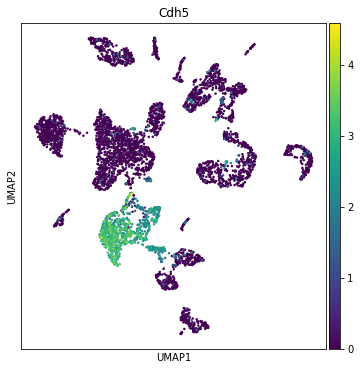

In [4]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color='Cdh5')

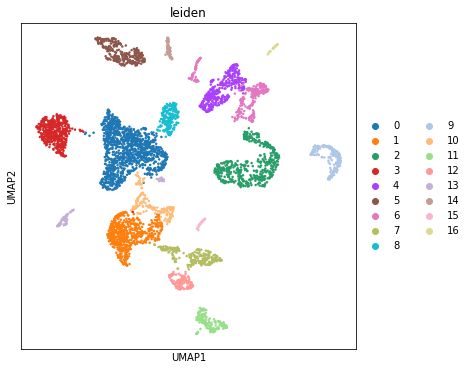

In [3]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = 'leiden')

In [5]:
ec_markers = adata.uns['markers']
ec_markers = ec_markers[(ec_markers.cluster == '1') & (ec_markers.pval_adj < 0.05) & (ec_markers.lfc > 1.5)]
ec_markers

,Gene,scores,pval_adj,lfc,cluster
19566,Fabp4,38.404152,0.0,7.357558,1
19567,Cdh5,38.241219,0.0,6.285158,1
19568,Cav1,38.071117,0.0,4.605687,1
19569,Flt1,37.972519,0.0,6.320522,1
19570,Egfl7,37.810642,0.0,5.874594,1
...,...,...,...,...,...
20925,P2ry2,2.511215,0.045055,2.368968,1
20928,Vegfc,2.500475,0.046302,1.625132,1
20929,Gbp3,2.496509,0.046769,1.562324,1
20931,Hoxd8,2.492298,0.047242,1.570327,1


# START GO example

In [6]:
!pip install goatools

In [ ]:
#first need to make background gene set

#https://www.ncbi.nlm.nih.gov/gene
#"10090"[Taxonomy ID] AND alive[property] AND genetype protein coding[Properties]
#human is 9606

#send to file




In [17]:
!mv path/to/Downloads/gene_result.txt .
!python path/to/miniconda3/envs/sc/bin/ncbi_gene_results_to_python.py -o genes_ncbi_mus_musculus_proteincoding.py gene_result.txt
#move created file to default import location so you dont have to make every time

      26,385 lines READ:  gene_result.txt
      26,371 geneids WROTE: genes_ncbi_mus_musculus_proteincoding.py


In [19]:
from genes_ncbi_mus_musculus_proteincoding import GENEID2NT as GeneID2nt_mus

In [20]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [21]:
#run one time to initialize
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

$ get http://purl.obolibrary.org/obo/go/go-basic.obo
requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

$ get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
$ gunzip gene2go.gz
go-basic.obo: fmt(1.2) rel(2022-03-22) 47,103 Terms


In [33]:
#run one time to initialize
mapper = {}

for key in GeneID2nt_mus:
    mapper[GeneID2nt_mus[key].Symbol] = GeneID2nt_mus[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

In [39]:
#run one time to initialize

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[10090])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

HMS:0:00:03.978075 427,869 annotations, 29,800 genes, 18,995 GOs, 1 taxids READ: gene2go 


In [41]:
#run one time to initialize
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_mus.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 67% 17,753 of 26,371 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 18,759 of 26,371 population items found in association

Load MF Ontology Enrichment Analysis ...
 65% 17,084 of 26,371 population items found in association


In [108]:
#run one time to initialize
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]


In [113]:
#pass list of gene symbols
def go_it(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 1]
    return GO


In [114]:
df = go_it(ec_markers.Gene.values)

input genes: 767
mapped genes: 735

Runing BP Ontology Analysis: current study set of 735 IDs.
 90%    664 of    735 study items found in association
100%    735 of    735 study items found in population(26371)
Calculating 12,632 uncorrected p-values using fisher_scipy_stats
  12,632 terms are associated with 17,753 of 26,371 population items
   3,516 terms are associated with    664 of    735 study items
  METHOD fdr_bh:
     299 GO terms found significant (< 0.05=alpha) (297 enriched +   2 purified): statsmodels fdr_bh
     551 study items associated with significant GO IDs (enriched)
      22 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 735 IDs.
 95%    699 of    735 study items found in association
100%    735 of    735 study items found in population(26371)
Calculating 1,836 uncorrected p-values using fisher_scipy_stats
   1,836 terms are associated with 18,759 of 26,371 population items
     471 terms are associated 

In [115]:
df

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes
0,GO:0001525,angiogenesis,biological_process,1.919384e-39,2.424566e-35,62,735,263,"[Ptk2, Egfl7, Pik3r6, Meox2, Tspan12, Ramp2, N..."
1,GO:0007155,cell adhesion,biological_process,6.007381e-21,3.794262e-17,64,735,581,"[Egfl7, Itga1, Lama4, Lama5, Cdh13, Epha2, Eph..."
2,GO:0030335,positive regulation of cell migration,biological_process,2.237660e-20,9.422042e-17,42,735,258,"[Mpzl1, Sema4c, Ptk2, Sema6a, Sema6b, Sema7a, ..."
3,GO:0016477,cell migration,biological_process,5.943413e-20,1.872937e-16,43,735,282,"[Coro6, Ptk2, Spata13, Wwc2, Fscn1, Lama5, Rnd..."
4,GO:0007275,multicellular organism development,biological_process,7.413460e-20,1.872937e-16,89,735,1089,"[Epha2, Epha4, Ephb4, Spred2, Id1, Fzd4, Id3, ..."
...,...,...,...,...,...,...,...,...,...
456,GO:0035005,1-phosphatidylinositol-4-phosphate 3-kinase ac...,molecular_function,6.939866e-04,4.496832e-02,3,735,7,"[Pik3c2a, Pik3cb, Pik3c2b]"
457,GO:0042392,sphingosine-1-phosphate phosphatase activity,molecular_function,6.939866e-04,4.496832e-02,3,735,7,"[Plpp6, Plpp3, Plpp1]"
458,GO:0030971,receptor tyrosine kinase binding,molecular_function,7.215019e-04,4.608336e-02,8,735,70,"[Hyal2, Angpt2, Dock4, Plcg1, Nck1, Nck2, Dusp..."
459,GO:0086075,gap junction channel activity involved in card...,molecular_function,7.757945e-04,4.878913e-02,2,735,2,"[Gja1, Gja5]"


In [117]:
df['per'] = df.n_genes/df.n_go

In [127]:
df = df[0:10]

In [132]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import textwrap

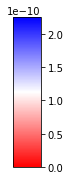

In [129]:
fig, ax = plt.subplots(figsize = (0.5, 2.75))

cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin = df.p_corr.min(), vmax = df.p_corr.max())

mapper = cm.ScalarMappable(norm = norm, cmap = cm.bwr_r)

cbl = mpl.colorbar.ColorbarBase(ax, cmap = cmap, norm = norm, orientation = 'vertical')

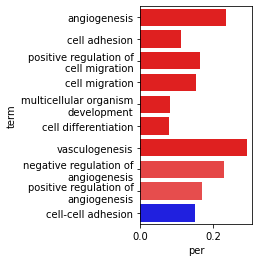

In [134]:
plt.figure(figsize = (2,4))



ax = sns.barplot(data = df, x = 'per', y = 'term', palette = mapper.to_rgba(df.p_corr.values))

ax.set_yticklabels([textwrap.fill(e, 22) for e in df['term']])

plt.show()